In [ ]:
!pip install xgboost

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import ensemble
from sklearn.metrics import (accuracy_score,
                             mean_squared_error,
                             precision_score, 
                             recall_score, 
                             f1_score, 
                             roc_curve, 
                             auc,
                             confusion_matrix)

In [2]:
from sklearn.inspection import permutation_importance
from sklearn.utils.fixes import parse_version

# Model Prediction

In [3]:
input_train = pd.read_csv("Training_Validation_Test_Datasets/task2_input_train.csv", index_col=0)
input_validate = pd.read_csv("Training_Validation_Test_Datasets/task2_input_validate.csv", index_col=0)
input_test = pd.read_csv("Training_Validation_Test_Datasets/task2_input_test.csv", index_col=0)

output_train = pd.read_csv("Training_Validation_Test_Datasets/task2_output_train.csv")["phq_sum"]
output_validate = pd.read_csv("Training_Validation_Test_Datasets/task2_output_validate.csv")["phq_sum"]
output_test = pd.read_csv("Training_Validation_Test_Datasets/task2_output_test.csv")["phq_sum"]

## 1. Gradient Boosting

In [4]:
lr = 0.1
n = 50
depth = 4
min_sample = 500

params = {"n_estimators": n,
          "max_depth": depth,
          "min_samples_split": min_sample,
          "learning_rate": lr,
          "loss": "squared_error",
          "random_state": 42}

reg = GradientBoostingRegressor(**params)
reg.fit(input_train, output_train)

predictions = reg.predict(input_validate)
mse = mean_squared_error(output_validate, predictions)
rmse = round(mse ** (1/2),4)
print("Validation RMSE:", rmse)

y_pred_gb = reg.predict(input_test)

Validation RMSE: 3.9012


## 2. XGBoost

In [5]:
dtrain = xgb.DMatrix(input_train, label=output_train)
dtest = xgb.DMatrix(input_test, label=output_test)
dvalidate = xgb.DMatrix(input_validate, label=output_validate)

params = {
        "objective": "reg:squarederror",  
        "eval_metric": "rmse",      
        "eta": 0.06,                      
        "max_depth": 3,      
        "subsample": 0.6,       
        "colsample_bytree": 0.2,
        "seed": 42
    }

evals = [(dtrain, "train")]
model = xgb.train(params, dtrain, num_boost_round=500, 
                  evals=evals, early_stopping_rounds=50, verbose_eval=100)

predictions = model.predict(dvalidate)
mse = mean_squared_error(output_validate, predictions)
rmse = round(mse ** (1/2),4)
print("Validation RMSE:", rmse)

y_pred_xgb = model.predict(dtest)

[0]	train-rmse:4.75161
[100]	train-rmse:3.56647
[200]	train-rmse:3.34156
[300]	train-rmse:3.18751
[400]	train-rmse:3.04850
[499]	train-rmse:2.92518
Validation RMSE: 3.9183


## 3. Random Forest

In [6]:
param_grid = {
    "n_estimators": 50,
    "max_depth": 10}

rf_best_model = RandomForestRegressor(
    n_estimators=param_grid["n_estimators"],
    max_depth=param_grid["max_depth"],
    random_state=42)

rf_best_model.fit(input_train, output_train)

predictions = rf_best_model.predict(input_validate)
mse = mean_squared_error(output_validate, predictions)
rmse = round(mse ** (1/2),4)
print("Validation RMSE:", rmse)

y_pred_rf = rf_best_model.predict(input_test)

Validation RMSE: 3.9695


## 4. Neural Networks

# Binary Task

In [8]:
output_test.value_counts()

phq_sum
0.0     238
1.0     170
2.0     126
3.0     112
4.0      78
5.0      69
6.0      60
7.0      40
8.0      34
9.0      30
10.0     28
11.0     21
12.0     19
13.0     18
14.0      9
18.0      9
19.0      8
17.0      8
15.0      8
16.0      6
20.0      5
21.0      2
24.0      2
23.0      2
26.0      1
22.0      1
Name: count, dtype: int64

In [9]:
y_test = np.array(output_test)
y_pred_gb = np.array(y_pred_gb)
# output_pred_nn = np.array(output_pred_nn)
y_pred_rf = np.array(y_pred_rf)
y_pred_xgb = np.array(y_pred_xgb)

In [10]:
# cutoff 10    
y_test_binary_10 = np.where(y_test >= 10, 1, 0)
y_pred_gb_binary_10 = np.where(y_pred_gb >= 10, 1, 0)
# y_pred_nn_binary_10 = np.where(output_pred_nn >= 10, 1, 0)
y_pred_rf_binary_10 = np.where(y_pred_rf >= 10, 1, 0)
y_pred_xgb_binary_10 = np.where(y_pred_xgb >= 10, 1, 0)

# cutoff 15    
y_test_binary_15 = np.where(y_test >= 15, 1, 0)
y_pred_gb_binary_15 = np.where(y_pred_gb >= 15, 1, 0)
# y_pred_nn_binary_15 = np.where(output_pred_nn >= 15, 1, 0)
y_pred_rf_binary_15 = np.where(y_pred_rf >= 15, 1, 0)
y_pred_xgb_binary_15 = np.where(y_pred_xgb >= 15, 1, 0)

In [12]:
pd.Series(y_test_binary_10).value_counts()

0    957
1    147
Name: count, dtype: int64

In [13]:
pd.Series(y_test_binary_15).value_counts()

0    1052
1      52
Name: count, dtype: int64

In [16]:
PHQ_CUTOFFS = [10, 15]

metrics_gb_10 = {}
metrics_rf_10 = {}
metrics_xgb_10 = {}

metrics_gb_15 = {}
metrics_rf_15 = {}
metrics_xgb_15 = {}

for PHQ_CUTOFF in PHQ_CUTOFFS:
    if PHQ_CUTOFF == 10:
        metrics_gb_10 = {
            "Accuracy": round(accuracy_score(y_test_binary_10, y_pred_gb_binary_10), 4),
            "F1 Score": round(f1_score(y_test_binary_10, y_pred_gb_binary_10), 4),
            "Precision": round(precision_score(y_test_binary_10, y_pred_gb_binary_10), 4),
            "Recall": round(recall_score(y_test_binary_10, y_pred_gb_binary_10), 4)
        }

        metrics_rf_10 = {
            "Accuracy": round(accuracy_score(y_test_binary_10, y_pred_rf_binary_10), 4),
            "F1 Score": round(f1_score(y_test_binary_10, y_pred_rf_binary_10), 4),
            "Precision": round(precision_score(y_test_binary_10, y_pred_rf_binary_10), 4),
            "Recall": round(recall_score(y_test_binary_10, y_pred_rf_binary_10), 4)
        }

        metrics_xgb_10 = {
            "Accuracy": round(accuracy_score(y_test_binary_10, y_pred_xgb_binary_10), 4),
            "F1 Score": round(f1_score(y_test_binary_10, y_pred_xgb_binary_10), 4),
            "Precision": round(precision_score(y_test_binary_10, y_pred_xgb_binary_10), 4),
            "Recall": round(recall_score(y_test_binary_10, y_pred_xgb_binary_10), 4)
        }

    elif PHQ_CUTOFF == 15:
        metrics_gb_15 = {
            "Accuracy": round(accuracy_score(y_test_binary_15, y_pred_gb_binary_15), 4),
            "F1 Score": round(f1_score(y_test_binary_15, y_pred_gb_binary_15), 4),
            "Precision": round(precision_score(y_test_binary_15, y_pred_gb_binary_15), 4),
            "Recall": round(recall_score(y_test_binary_15, y_pred_gb_binary_15), 4)
        }

        metrics_rf_15 = {
            "Accuracy": round(accuracy_score(y_test_binary_15, y_pred_rf_binary_15), 4),
            "F1 Score": round(f1_score(y_test_binary_15, y_pred_rf_binary_15), 4),
            "Precision": round(precision_score(y_test_binary_15, y_pred_rf_binary_15), 4),
            "Recall": round(recall_score(y_test_binary_15, y_pred_rf_binary_15), 4)
        }

        metrics_xgb_15 = {
            "Accuracy": round(accuracy_score(y_test_binary_15, y_pred_xgb_binary_15), 4),
            "F1 Score": round(f1_score(y_test_binary_15, y_pred_xgb_binary_15), 4),
            "Precision": round(precision_score(y_test_binary_15, y_pred_xgb_binary_15), 4),
            "Recall": round(recall_score(y_test_binary_15, y_pred_xgb_binary_15), 4)
        }


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [17]:
metrics_gb_10

{'Accuracy': 0.8668, 'F1 Score': 0.2538, 'Precision': 0.5, 'Recall': 0.1701}

### Confusion Matrix Plot

In [18]:
def plot_confusion_matrices_row(y_true, y_preds, titles):
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))  

    for ax, y_pred, title in zip(axes, y_preds, titles):
        cm = confusion_matrix(y_true, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=["Pred 0", "Pred 1"],
                    yticklabels=["True 0", "True 1"],
                    ax=ax)
        ax.set_title(title)
        ax.set_xlabel("Predicted")
        ax.set_ylabel("Actual")

    plt.tight_layout()
    plt.show()

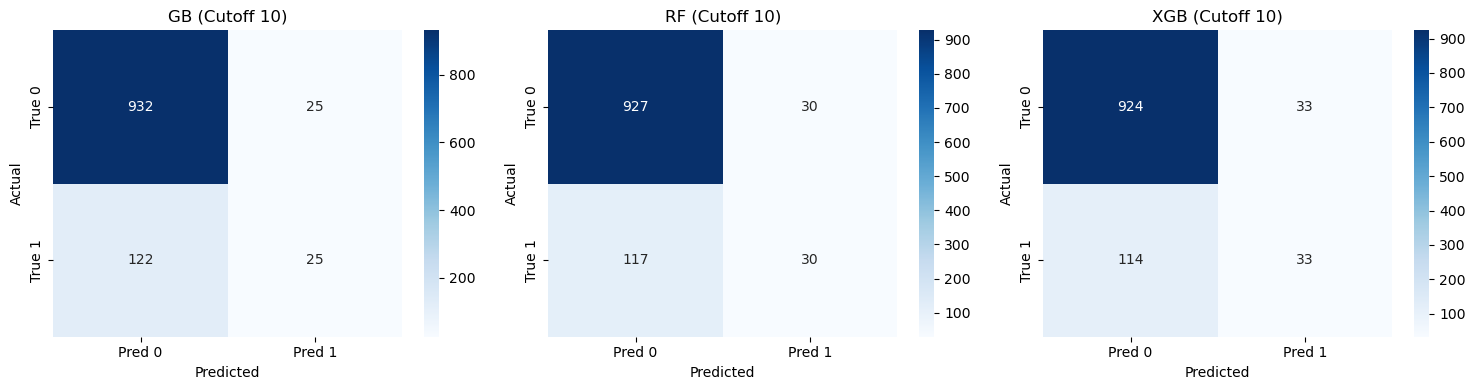

In [20]:
plot_confusion_matrices_row(
    y_true=y_test_binary_10,
    y_preds=[y_pred_gb_binary_10, y_pred_rf_binary_10, y_pred_xgb_binary_10],
    titles=["GB (Cutoff 10)", "RF (Cutoff 10)", "XGB (Cutoff 10)"]
)

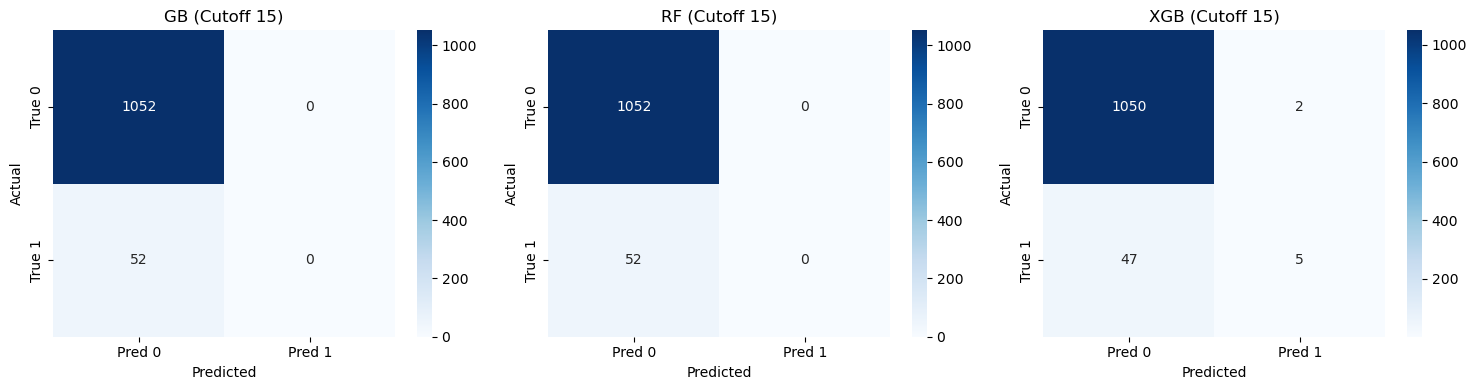

In [21]:
plot_confusion_matrices_row(
    y_true=y_test_binary_15,
    y_preds=[y_pred_gb_binary_15, y_pred_rf_binary_15, y_pred_xgb_binary_15],
    titles=["GB (Cutoff 15)", "RF (Cutoff 15)", "XGB (Cutoff 15)"]
)

### Accuracy Plot

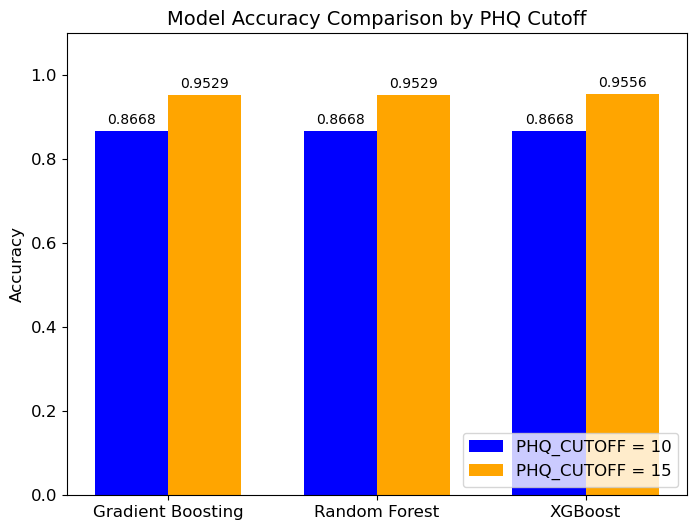

In [24]:
accuracies_cutoff_10 = {
    "Gradient Boosting": metrics_gb_10["Accuracy"],
    "Random Forest": metrics_rf_10["Accuracy"],
    "XGBoost": metrics_xgb_10["Accuracy"]
}

accuracies_cutoff_15 = {
    "Gradient Boosting": metrics_gb_15["Accuracy"],
    "Random Forest": metrics_rf_15["Accuracy"],
    "XGBoost": metrics_xgb_15["Accuracy"]
}


models = list(accuracies_cutoff_10.keys())
x = np.arange(len(models))
width = 0.35

fig, ax = plt.subplots(figsize=(8, 6))
bars1 = ax.bar(x - width/2, accuracies_cutoff_10.values(), width, label="PHQ_CUTOFF = 10", color="blue")
bars2 = ax.bar(x + width/2, accuracies_cutoff_15.values(), width, label="PHQ_CUTOFF = 15", color="orange")


for bars in [bars1, bars2]:
    for bar in bars:
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{bar.get_height():.4f}', ha='center', va='bottom', fontsize=10)

ax.set_ylim(0, 1.1)
ax.set_ylabel("Accuracy", fontsize=12)
ax.set_xticks(x)
ax.set_xticklabels(models, fontsize=12)
ax.legend(loc='lower right', fontsize=12)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title("Model Accuracy Comparison by PHQ Cutoff", fontsize=14)
plt.show()

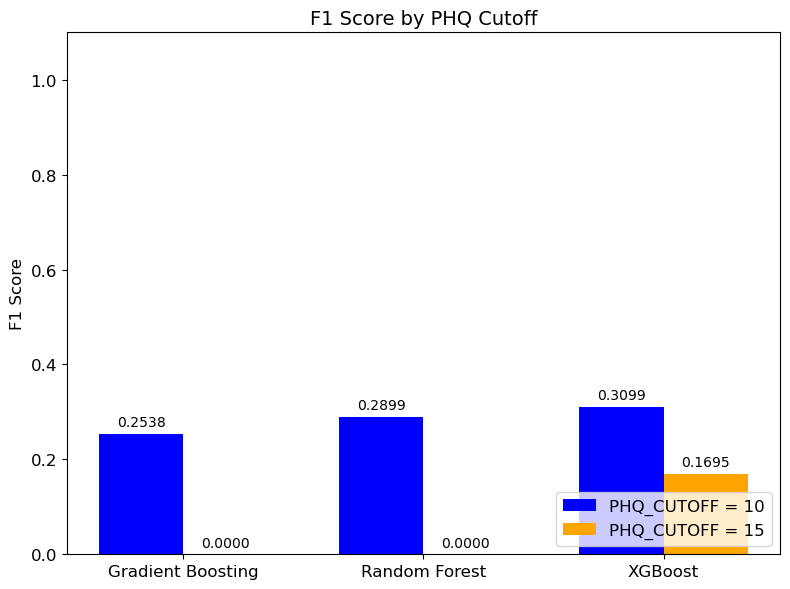

In [25]:
f1scores_cutoff_10 = {
    "Gradient Boosting": metrics_gb_10["F1 Score"],
    "Random Forest": metrics_rf_10["F1 Score"],
    "XGBoost": metrics_xgb_10["F1 Score"]
}

f1scores_cutoff_15 = {
    "Gradient Boosting": metrics_gb_15["F1 Score"],
    "Random Forest": metrics_rf_15["F1 Score"],
    "XGBoost": metrics_xgb_15["F1 Score"]
}

models = list(f1scores_cutoff_10.keys())
x = np.arange(len(models))
width = 0.35

fig, ax = plt.subplots(figsize=(8, 6))  
bars1 = ax.bar(x - width/2, f1scores_cutoff_10.values(), width, label="PHQ_CUTOFF = 10", color="blue")
bars2 = ax.bar(x + width/2, f1scores_cutoff_15.values(), width, label="PHQ_CUTOFF = 15", color="orange")

for bars in [bars1, bars2]:
    for bar in bars:
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{bar.get_height():.4f}', ha='center', va='bottom', fontsize=10)

ax.set_ylim(0, 1.1)
ax.set_ylabel("F1 Score", fontsize=12)
ax.set_xticks(x)
ax.set_xticklabels(models, fontsize=12)
ax.legend(loc='lower right', fontsize=12)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title("F1 Score by PHQ Cutoff", fontsize=14)
plt.tight_layout()
plt.show()

### ROC Curve Plot

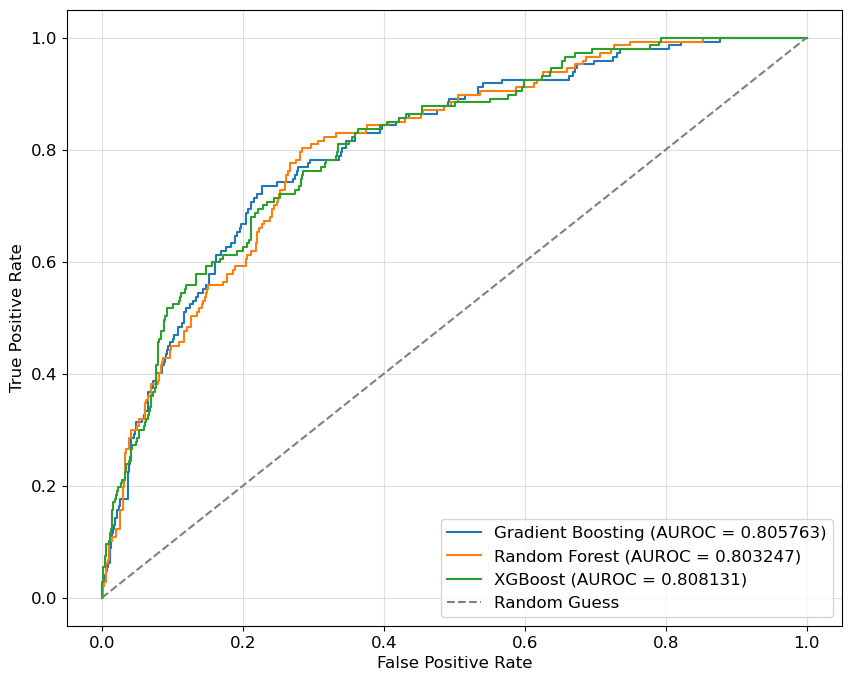

In [31]:
# cut off 10
def plot_auroc(y_test_binary_10, y_pred_gb, y_pred_rf, y_pred_xgb):
    models = {
        "Gradient Boosting": y_pred_gb,
        "Random Forest": y_pred_rf,
#         "Neural Networks": y_pred_nn,
        "XGBoost": y_pred_xgb
    }

    plt.figure(figsize=(10, 8))
    for model_name, y_pred in models.items():
        fpr, tpr, _ = roc_curve(y_test_binary_10, y_pred)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"{model_name} (AUROC = {roc_auc:.6f})")

    plt.plot([0, 1], [0, 1], color="gray", linestyle="--", label="Random Guess")
    plt.xlabel("False Positive Rate", fontsize=12)  
    plt.ylabel("True Positive Rate", fontsize=12)  
    plt.legend(loc="lower right", fontsize=12)
    plt.grid(alpha=0.4)
    plt.xticks(fontsize=12) 
    plt.yticks(fontsize=12) 
    plt.show()

plot_auroc(y_test_binary_10, y_pred_gb, y_pred_rf, y_pred_xgb)

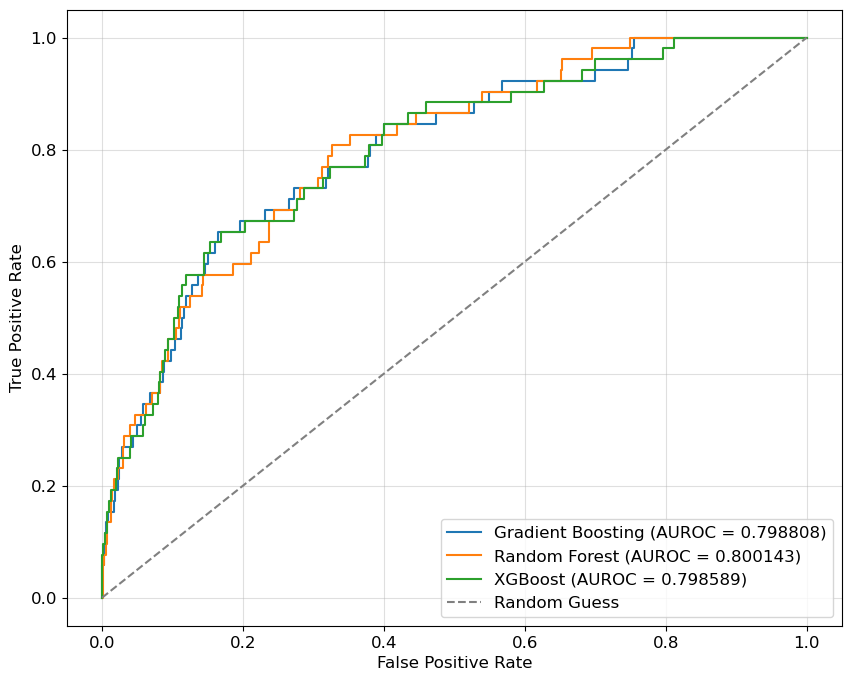

In [32]:
# cut off 15
def plot_auroc(y_test_binary_15, y_pred_gb, y_pred_rf, y_pred_xgb):
    models = {
        "Gradient Boosting": y_pred_gb,
        "Random Forest": y_pred_rf,
#         "Neural Networks": y_pred_nn,
        "XGBoost": y_pred_xgb
    }

    plt.figure(figsize=(10, 8))
    for model_name, y_pred in models.items():
        fpr, tpr, _ = roc_curve(y_test_binary_15, y_pred)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"{model_name} (AUROC = {roc_auc:.6f})")

    plt.plot([0, 1], [0, 1], color="gray", linestyle="--", label="Random Guess")
    plt.xlabel("False Positive Rate", fontsize=12)  
    plt.ylabel("True Positive Rate", fontsize=12)  
    plt.legend(loc="lower right", fontsize=12)
    plt.grid(alpha=0.4)
    plt.xticks(fontsize=12) 
    plt.yticks(fontsize=12) 
    plt.show()

plot_auroc(y_test_binary_15, y_pred_gb, y_pred_rf, y_pred_xgb)

cutoff=10 更适合用作早期筛查工具；cutoff=15 更适合做重度预警或介入决策

AUROC 的意义（再强调一次）：
它不是 accuracy，不是 precision，而是模型能否把高风险样本排在低风险样本前面的一种衡量。

所以你这张图说明：

不管具体 cutoff 设置多少，你的模型都具有较强的排序能力，对实际分数高的患者给出了更高的预测值。